# 中介分析

### 黄荣贵（复旦大学社会学系）

## 中介分析基本框架

假定\\(Y\\)是因变量，\\(X\\)是自变量，\\(M\\)是中介变量；其中，\\(X\\)部分（或完全）通过影响\\(M\\)而影响\\(Y\\)。这一关系可以表述为：

$$Y = \alpha_y + \beta_{yx} X + \epsilon_y$$

$$M = \alpha_m + \beta_{mx} X + \epsilon_m$$

$$Y = \alpha + \beta_{m} M + \beta_{x} X + \epsilon$$

如果我们将第二个公式代入到第三个公式，然后与第一个公式进行比较可以发现：

$$ \beta_{mx}\beta_m = \beta_{yx} - \beta_x$$

因此，只要我们估计第一个和第三个模型就可以得到中介效应 $\beta_{mx}\beta_m$。然而，为了估计中介效应是否显著，我们还需要估计相应的标准误$\widehat{\sigma_{\beta_{mx}\beta_m}}$。其中一种估计方法（Sobel，1982）如下：

$$\widehat{\sigma_{\beta_{mx}\beta_m}} = \sqrt{\widehat{\beta_{mx}^2} \widehat{\sigma^2_{\beta_{m}}}+\widehat{\beta_{m}^2} \widehat{\sigma^2_{\beta_{mx}}} }$$

可见，为了估计中介效应的标准误，需要同时估计第二和第三个模型。

得到标准误后，可以使用正态分布来估计其置信区间。然而，值得注意的是，由于中介效应呈偏态分布，根据上述标准误计算的置信区间无法很好反映真实的区间。

In [1]:
data(Prestige, package="carData")

names(Prestige)

[1] "education" "income"    "women"     "prestige"  "census"    "type"

### 例子:教育程度在多大程度上通过收入而影响职业声望？

#### 手工计算中介效应

通过拟合三个模型，我们可以通过两种不同的方法计算中介效应。

In [2]:
mod_y <- lm(prestige ~ education, data = Prestige)
mod_m <- lm(income ~ education, data = Prestige)
mod_full <- lm(prestige ~ income + education, data = Prestige)
coef(mod_m)['education'] * coef(mod_full)['income']  # mediation effect by multiplication

education 
 1.223433

In [3]:
med_eff <- coef(mod_y)['education'] - coef(mod_full)['education']  # mediation effect by subtraction
med_eff  # save for futher use

education 
 1.223433

下面我们直接计算中介效应的标准误，以及对95%置信的估计。

In [4]:
sd_eff_sq <- coef(mod_m)['education']^2 * vcov(mod_full)['income', 'income'] + 
             coef(mod_full)['income']^2 * vcov(mod_m)['education', 'education']
sd_eff <- sqrt(sd_eff_sq)  # SE of mediation effect
sd_eff

education 
0.2655414

In [5]:
med_eff / sd_eff # Z value

education 
 4.607317

In [6]:
c(med_eff - 1.96*sd_eff, med_eff + 1.96*sd_eff)  # 95% CI

education education 
0.7029722 1.7438945

我们可以把上面的计算过程封装起来，从而得到计算中介效应及其区间的函数。

#### 使用sobel函数进行中介分析

In [7]:
library(multilevel)

Loading required package: nlme
Loading required package: MASS


In [8]:
with(Prestige, sobel(education, income, prestige))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-10.731982,3.6770883,-2.918609,4.343443e-03
pred,5.360878,0.3319882,16.147796,1.286264e-29
,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-6.847778720,3.2189770963,-2.127315,3.587840e-02
pred,4.137444384,0.3489120233,11.858131,1.032202e-20
med,0.001361166,0.0002242121,6.070886,2.355196e-08
,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-2853.5856,1407.0392,-2.028078,4.521163e-02
pred,898.8128,127.0354,7.075294,2.079192e-10


### 通过bootstrap法计算中介效应及其置信区间


Bollen和Stine是这个方法的倡导者。相关讨论详见：Bollen, K. A. & Stine, R. 1990. Direct and indirect effects: classical and bootstrap estimates of variability Sociological Methodology, 20, 115–140.

首先，定义一个函数计算中介效应。该函数具有两个参数，第一个参数是数据框，第二个参数是bootstrap法随机抽取的案例的标识（行数）。

In [9]:
coef_diff <- function(d, i){
    dat <- d[i, ]
    mod_y <- lm(prestige ~ education, data = dat)
    mod_full <- lm(prestige ~ income + education, data = dat)
    med_eff <- coef(mod_y)['education'] - coef(mod_full)['education'] ## mediation effect by subtraction
    med_eff
}

接下来，加载boot程序包，并调用同名函数进行bootstrap计算。其中，我们将抽样次数R设置为1000，stype参数设置为i。

In [10]:
library(boot)

(med.boot <- boot(Prestige, coef_diff, R = 1000, stype="i"))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Prestige, statistic = coef_diff, R = 1000, stype = "i")


Bootstrap Statistics :
    original     bias    std. error
t1* 1.223433 0.03059583    0.253062

original: 原始样本计算得到的统计量

bias: R次bootstrap得到样本量的均值 - original

std.error: R次bootstrap样本统计量的标准差

第三，调用boot.ci函数计算置信区间。与Bollen and Stine（1990）相一致，我们计算的是percentile置信区间（type = "perc"）。

In [11]:
boot.ci(med.boot, type = "perc")

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = med.boot, type = "perc")

Intervals : 
Level     Percentile     
95%   ( 0.820,  1.801 )  
Calculations and Intervals on Original Scale

通过密度图来检查bootstrap结果的分布。同时，通过curve函数增加一个正态分布曲线来做参考。结果显示，bootstrap结果略显偏态分布。

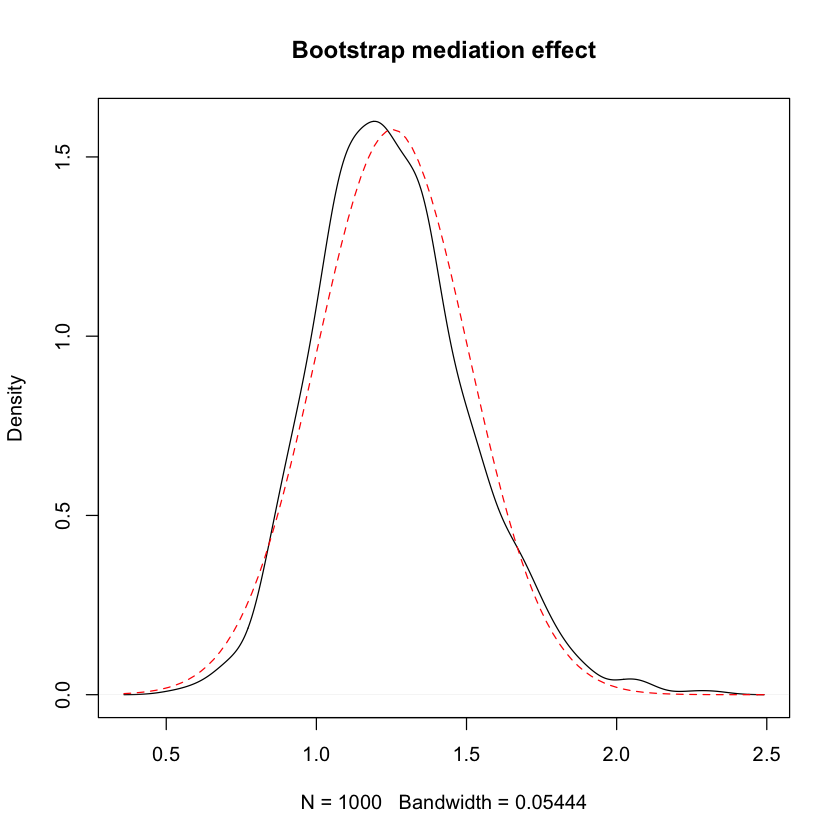

In [12]:
plot(density(med.boot$t), main = "Bootstrap mediation effect")
curve(dnorm(x, mean=mean(med.boot$t), sd=sd(med.boot$t)), add = TRUE, col='red', lty=2)

In [13]:
coef_diff2 <- function(d, i){
    dat <- d[i, ]
    mod_y <- lm(prestige ~ education, data = dat)
    mod_full <- lm(prestige ~ income + education, data = dat)
    med_eff <- coef(mod_y)['education'] - coef(mod_full)['education']  # mediation effect by subtraction
    pct <- med_eff / coef(mod_y)['education']
    c(med_eff, pct)
}

(med.boot2 <- boot(Prestige, coef_diff2, R = 1000, stype="i"))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Prestige, statistic = coef_diff2, R = 1000, stype = "i")


Bootstrap Statistics :
     original      bias    std. error
t1* 1.2234333 0.031332396  0.25454835
t2* 0.2282151 0.005063449  0.04792437

In [14]:
boot.ci(med.boot2, conf=0.95, type="perc", index=1)

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = med.boot2, conf = 0.95, type = "perc", index = 1)

Intervals : 
Level     Percentile     
95%   ( 0.795,  1.811 )  
Calculations and Intervals on Original Scale

In [32]:
boot.ci(med.boot2, conf=0.95, type="perc", index=2)

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = med.boot2, conf = 0.95, type = "perc", index = 2)

Intervals : 
Level     Percentile     
95%   ( 0.1516,  0.3456 )  
Calculations and Intervals on Original Scale

## 贝叶斯中介分析：单层次回归

通过贝叶斯方法计算上述中介分析可以得到中介效应的分布，从而可以直接计算中介效应的置信区间，而无需依赖对中介效应抽样分布的假定（详见Yuan and MacKinnon. (2009). Bayesian Mediation Analysis. Psychol Methods. 14(4): 301–322. ）。我们可以使用rjags程序包进行计算。

首先，我们使用BUGS/JAGS语言编写上述模型，并将模型以一个字符对象的形式保存起来。在下面的模型设定中：
* N表示样本量
* 在BUGS语言中，~ 表示分布，<- 则表示确定性关系
* 在BUGS语言中， dnorm(正态分布)的第二个参数是precision，是方差的倒数
* 在BUGS语言中，dgamma表示gamma分布，该分布描述方差先验分布，a和b这两个参数设置为0.001 意味着无信息先验分布
* 通过定义theta =  beta_mx * beta_m，我们可以得到中介效应

In [22]:
mediation_model <- "
model {
   for(i in 1:N)
   {
      m[i] ~ dnorm(mean.m[i], prec.m)
      mean.m[i] <- alpha_m + beta_mx * x[i]
      y[i] ~ dnorm(mean.y[i], prec.y)
      mean.y[i] <- alpha + beta_m * m[i] + beta_x * x[i]
   }
   alpha_m ~ dnorm(0, 1.0E-6)
   beta_mx ~ dnorm(0, 1.0E-6)
   alpha ~ dnorm(0, 1.0E-6)
   beta_m ~ dnorm(0, 1.0E-6)
   beta_x ~ dnorm(0, 1.0E-6)
   # dgamma (a, b) is a gamma distribution with the shape parameter a and
   # inverse scale parameter b.
   prec.y ~ dgamma(0.001, 0.001)
   prec.m ~ dgamma(0.001, 0.001)
   theta <-  beta_mx * beta_m
}
"

第二，将所需要的数据构建成一个列表。

第三，加载rjags程序包，调用jags.model生成一个BUGS模型。值得注意的是，jags.model的第一个参数是文本连接（或保存在电脑中的文本文件），因此我们需要通过textConnect函数将上述字符格式的BUGS模型定义转换为文本连接。

第四，通过update函数，开始更新模型。

第五，通过coda.samples函数抽样，得到我们所需要的信息（在这里例子中，我们关心的是theta）。

最后，通过summary函数和plot函数得到theta的分布。

In [23]:
DL <- list(N = nrow(Prestige),
           y = Prestige$prestige,
           x = Prestige$education,
           m = Prestige$income
          )

library(rjags)
jags <- jags.model(textConnection(mediation_model), data=DL,n.chains=4, n.adapt=100)
update(jags, 5000)
samps <- coda.samples(jags, c("theta"), 2000)
summary(samps)
# plot(samps)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 204
   Unobserved stochastic nodes: 7
   Total graph size: 818

Initializing model




Iterations = 5001:7000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      1.009088       0.202368       0.002263       0.007522 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.6264 0.8712 1.0019 1.1386 1.4208 


从上述图形可知，模型混合得良好（可以进一步通过诊断分析来判断模型是否混合良好），得到的分布可认为接近理论分布。
* 分析结果现实，中介效应的分别略呈右偏态。
* 比较贝叶斯中介分析和Sobel方法的结果可知，Sobel方法略高估了中介效应。